# 6. Deep Learning for Text and Sequences

## Working with Text Data

Deep learning for natural-language processing is pattern recognition applied to words, sentences and paragraphs like how deep learning for computer vision is applied to pixels. Applications of these techniques can be found in document classification, sentiment analysis, author identification and even QA (in a constrained context). These deep learning do not truly understand text in a human sense, but these models can map the statistical structure of written language, which is sufficient to solve many simple textual tasks.

Before processing text, models need to vectorize text - transforming text to numeric tensors. This can be done in multiple ways:

1. segment text to words and transform each word to a vector
2. segment text to charactes and transform each character to a vector
3. segment text to n-grams (2-grams, 3-grams etc, where 1-gram is the word level tokenisation) and transform each n-gram to a vector.

Collectively, the different units into which we can break down text are called <b>tokens</b> and breaking text into tokens is called <b>tokenisation</b>. There are generally two common ways to do so:

1. one-hot encoding of tokens
2. word embedding

### One-hot Encoding

One-hot encoding is the most common, most basic way to turn a token to a vector. This can be done using Keras, sklearn or nltk. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.datasets import imdb
import tensorflow as tf

In [2]:
# Moby Dick & Sherlock Holmes
samples = ['The pale Usher—threadbare in coat, heart, body, and brain; I see him now.', 
           'He loved to dust his old grammars; it somehow mildly reminded him of his mortality.']

In [3]:
# Tokenisation using Keras
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=50)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
print(one_hot_results[0])
print(len(tokenizer.word_index))

[0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
26


In [4]:
# Tokenisation using sklearn
cv = CountVectorizer()
one_hot_results2 = cv.fit_transform(samples)
print(len(cv.get_feature_names()))
print(one_hot_results2[0].A)

26
[[1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1]]


### Word Embedding

Another powerful way to associate a vector with a word is to use dense <b>word vectors</b>, or <b>word embeddings</b>. While the vectors obtained through one-hot encoding is sparse and high dimensional, word embeddings are low-dimensional, dense floating-point vectors. Word embeddings are learnt from data. Common word embeddings are 256-dimensional, 512-dimensional or 1024-dimensional, while common one-hot encoded vectors are 20000-dimensional or larger if there are 20000 words in the vocabulary. There are two ways to learn word embeddings:

1. learn word-embeddings jointly with the problem at hand. Here, you start with random word vectors and then learn word vectors the same way you learn the weights of a neural network
2. load word embeddings that were precomputed using a different task, or using <b>pretrained word embeddings</b>

#### Learning Word Embeddings

Generally, we want to represent semantic relationships between words with geometric relationships. For example, synonyms should be mapped to similar word vectors, and generally, the geometric distance between two words reflect the semantic relationship between them (words with different meanings are embedded at points far away from each other, while words with similar meanings are close to each other). Also, we can use directions to imply relationships between words.

<img src="img62.png" width="625">

In this example, there are 4 words - `cat`, `tiger`, `dog`, `wolf`. When we move up, we can say this direction is "domestic to wild" transition. When we move to the left, we can say this is a "canine to feline" transition. So we can put `pig -> boar` in the first transition and `puppy -> kitten` to the second one.

<img src="img61.png" width="225">

General real-world transformations include gender like `king/queen`, `actor/actress`, plural `bottle/bottles` etc. There is not such ideal word-embedding space for all NLP tasks, but we can generally use the same word embeddings for similar tasks / topics. The word embedding for legal documents is likely different to that of reviews.

In Keras, we learn the embedding using the `Embedding` layer. It is best understood as a dictionary that maps integer indices to dense vectors. It takes integers as input, and looks up these integers in an internal dictionary, and returns the associated vectors. It is essentially a dictionary lookup.

The `Embedding` layer takes an input as a 2D tensor integers of shape `(samples, sequence_length)`, where each entry is a sequence of integers. All sequences in a batch must have the same length, so sequences that are shorter should be padded while sequences that are longer should be truncated. When you instantiate an `Embedding` layer, the weights are initially random. During training, these weights are gradually adjusted via backpropagation, structuring the space into something the downstream model can exploit. Once fully trained, the embedding space will show structure that is specislised for the specific ML problem.

This layer returns a 3D floating-point tensor of shape `(samples, sequence_length, embedding_dimensionality)` and this can be processed by an RNN layer or a 1D convolution layer.

Consider applying this to the **reviews** problem. We add a network to learn 8-dimensional embeddings for each of the 10000 words, turn the input ineger sequences to embedded sequences, flatten the tensor to 2D and train a single `Dense` layer for classification.

In [5]:
# Ingestion
###########
VOCABULARY_SIZE = 10000
DOCUMENT_MAX_LENGTH = 20
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=VOCABULARY_SIZE)

# Preprocessing
###############
x_train = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=DOCUMENT_MAX_LENGTH)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=DOCUMENT_MAX_LENGTH)

In [6]:
# Instantiate Model
###################
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(VOCABULARY_SIZE, 8, input_length=DOCUMENT_MAX_LENGTH))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile
#########
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
# Train
#######
history = model.fit(x_train, train_labels, 
                    epochs=10, batch_size=32, 
                    validation_split=0.2, verbose=0)
model.save('chap06_imdb__v1_embed_8d.h5')
print(history.history['val_accuracy'][-1:])

[0.7445999979972839]


Validation accuracy is 73% which is pretty good considering just looking at the first 20 words of the review, but flattening the embedded sequences and training a single `Dense` layer on top leads ot a model that treats each word in the input sequence separately, wihtout considering inter-word relationships and sentence structure. It is much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole.

#### Using Pretrained Word Embeddings

Besides training your own word embeddings, you can use a precomputed embedding space that is precomputed and exhibits useful properties. This is similar to using pretrained convnets for image classification, and is useful when the dataset for the ML problem is relatively small and when the features are reasonably generic: the semantic features for text, like the visual features for computer vision.

There are pretrained word embeddings. The more common ones are Word2Vec by Google in 2013, and GloVe by Stanford researchers in 2014.

In [8]:
# Ingestion, Labelling
######################
df = pd.read_csv('IMDB Dataset.csv')
df['label'] = df['sentiment'].map({'positive' : 1, 'negative' : 0})
display(df.sample(4))
df.drop(['sentiment'], axis=1, inplace=True)
print(df['label'].value_counts())

,review,sentiment,label
11167,This film is about the life of Queen Victoria ...,positive,1
16570,"i loved catcher in the rye, it happens to be m...",positive,1
35764,This series would have been a lot better if th...,negative,0
9156,"""Mame"" is a disgrace to many things--to Lucill...",negative,0


1    25000
0    25000
Name: label, dtype: int64


In [9]:
# Preprocessing
###############
EXPT2_VOCABULARY_SIZE = 10000
EXPT2_DOCUMENT_MAX_LENGTH = 20

EXPT2_TRAIN_DOC_COUNT = 200
EXPT2_VALIDATION_DOC_COUNT = 10000

expt2_tokenizer2 = tf.keras.preprocessing.text.Tokenizer(num_words=EXPT2_VOCABULARY_SIZE)
expt2_tokenizer2.fit_on_texts(df['review'])
expt2_sequences = expt2_tokenizer2.texts_to_sequences(df['review'])
print(len(expt2_tokenizer2.word_index))

GLOVE_FN = 'glove.6B.100d.txt'

124252


In [10]:
imdb_corpus = tf.keras.preprocessing.sequence.pad_sequences(expt2_sequences, maxlen=EXPT2_DOCUMENT_MAX_LENGTH)
imdb_labels = np.asarray(df['label'])
print(imdb_corpus.shape)
print(imdb_labels.shape)

(50000, 20)
(50000,)


In [11]:
# Train-Test split
EXPT2_VALIDATION_INDEX_START = EXPT2_TRAIN_DOC_COUNT + EXPT2_VALIDATION_DOC_COUNT

x_train = imdb_corpus[:EXPT2_TRAIN_DOC_COUNT]
y_train = imdb_labels[:EXPT2_TRAIN_DOC_COUNT]
x_val = imdb_corpus[EXPT2_TRAIN_DOC_COUNT:EXPT2_VALIDATION_INDEX_START] 
y_val = imdb_labels[EXPT2_TRAIN_DOC_COUNT:EXPT2_VALIDATION_INDEX_START]

In [12]:
# For testing
# print(x_train.shape)
# print(y_train.shape)
# print(x_val.shape)
# print(y_val.shape)

To preprocess the embeddings, first ingest the embeddings into a dictionary where the key is the word and the value is the vector.

Then, build an embedding matrix where the each entry in the word index contains the preloaded vector from Glove.

In [13]:
# Preprocessing GLOVE
#####################

# Read from the embedding file and store as key-value pair where key is word and value is vector
glove_embeddings = dict()
with open(GLOVE_FN, 'r') as f:
    for l in f:
        w, coefs = l.split()[0], np.asarray(l.split()[1:], dtype='float32')
        glove_embeddings[w] = coefs
        
# Assign the vector to the word using the word_index fitted from the tokenizer
EMBEDDING_DIMENSIONS = 100
expt2_wordembeddings = np.zeros((EXPT2_VOCABULARY_SIZE, EMBEDDING_DIMENSIONS))
for w, i in expt2_tokenizer2.word_index.items():
    if i < EXPT2_VOCABULARY_SIZE:
        try:
            embedding_vector = glove_embeddings[w]
            expt2_wordembeddings[i] = embedding_vector
        except KeyError:
            pass

To understand the performance with and without the embeddings, consider a model with no pretrained embeddings.

In [14]:
# Instantiate Model
###################
tf.keras.backend.clear_session()
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(EXPT2_VOCABULARY_SIZE, EMBEDDING_DIMENSIONS,
                                     input_length=EXPT2_DOCUMENT_MAX_LENGTH))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(32, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [15]:
# Compile
#########
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           1000000   
_________________________________________________________________
flatten (Flatten)            (None, 2000)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                64032     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,064,065
Trainable params: 1,064,065
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# Train
##############
history2 = model2.fit(x_train, y_train, 
                    epochs=10, batch_size=32, 
                      validation_data=(x_val, y_val))
model2.save('chap06_imdb__v2_embed_100d.h5')

Epoch 1/10
7/7 [==============================] - 1s 72ms/step - loss: 0.6930 - accuracy: 0.5100 - val_loss: 0.6929 - val_accuracy: 0.5093
Epoch 2/10
7/7 [==============================] - 0s 66ms/step - loss: 0.6138 - accuracy: 0.9900 - val_loss: 0.6928 - val_accuracy: 0.5103
Epoch 3/10
7/7 [==============================] - 1s 78ms/step - loss: 0.5416 - accuracy: 1.0000 - val_loss: 0.6925 - val_accuracy: 0.5174
Epoch 4/10
7/7 [==============================] - 1s 87ms/step - loss: 0.4420 - accuracy: 1.0000 - val_loss: 0.6966 - val_accuracy: 0.5141
Epoch 5/10
7/7 [==============================] - 1s 100ms/step - loss: 0.3228 - accuracy: 1.0000 - val_loss: 0.6990 - val_accuracy: 0.5192
Epoch 6/10
7/7 [==============================] - 0s 68ms/step - loss: 0.2155 - accuracy: 1.0000 - val_loss: 0.7091 - val_accuracy: 0.5173
Epoch 7/10
7/7 [==============================] - 0s 66ms/step - loss: 0.1368 - accuracy: 1.0000 - val_loss: 0.7100 - val_accuracy: 0.5249
Epoch 8/10
7/7 [==========

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.215495,1.0,0.709106,0.5173,6
6,0.136767,1.0,0.709988,0.5249,7
7,0.084442,1.0,0.730148,0.5208,8
8,0.052056,1.0,0.731452,0.5234,9
9,0.032676,1.0,0.749353,0.5220,10


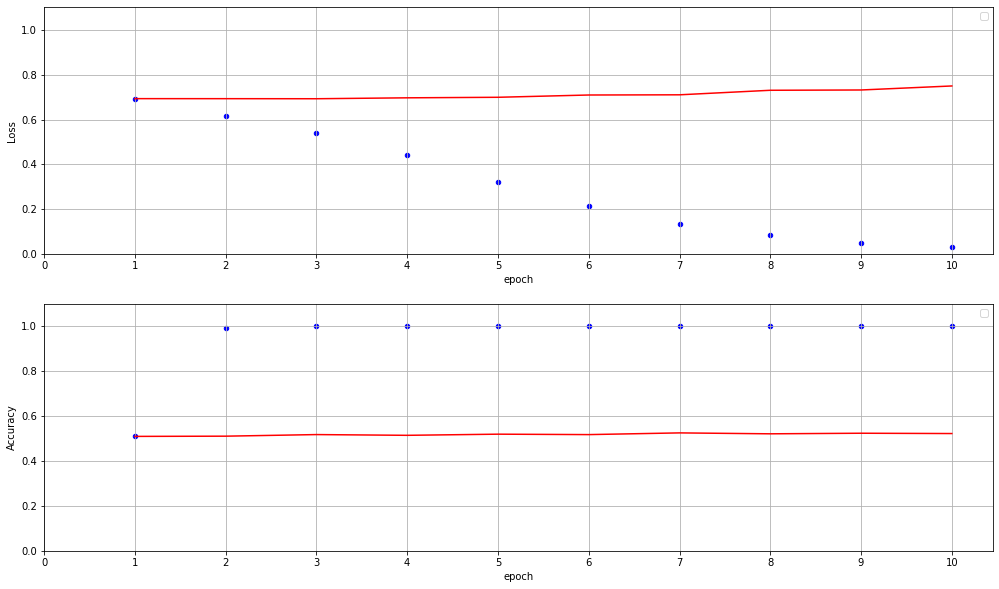

In [17]:
metrics_df = pd.DataFrame(history2.history)
metrics_df['epoch'] = metrics_df.index+1
display(metrics_df.tail())

fig = plt.figure(figsize=(17,10))
ax1, ax2 = fig.add_subplot(2,1,1), fig.add_subplot(2,1,2)
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
ax1.set_ylabel("Loss")
ax1.grid('GAINSBORO')
ax1.legend([])
ax1.set_ylim(0,1.1)
ax1.set_xticks(range(0,11))

metrics_df.plot(kind='scatter', x='epoch', y='accuracy', ax=ax2, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_accuracy', ax=ax2, label='validation', color='red',)
ax2.set_ylabel("Accuracy")
ax2.grid('GAINSBORO')
ax2.set_xticks(range(0,11))
ax2.legend([])
ax2.set_ylim(0,1.1)
plt.show()

This contains word embeddings only learnt from the training data. Validation accuracy cannot improve beyond 50%. It is clear that this model performance is rather poor for a binary prediction task.

In [18]:
# Instantiate Model
###################
tf.keras.backend.clear_session()
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Embedding(EXPT2_VOCABULARY_SIZE, EMBEDDING_DIMENSIONS,
                                     input_length=EXPT2_DOCUMENT_MAX_LENGTH))
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(32, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.layers[0].set_weights([expt2_wordembeddings])
model3.layers[0].trainable = False

# Compile
#########
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
print(model3.summary())

# Train
##############
history3 = model3.fit(x_train, y_train, 
                    epochs=10, batch_size=32, 
                      validation_data=(x_val, y_val))
model3.save('chap06_imdb__v3_glove.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           1000000   
_________________________________________________________________
flatten (Flatten)            (None, 2000)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                64032     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,064,065
Trainable params: 64,065
Non-trainable params: 1,000,000
_________________________________________________________________
None
Epoch 1/10
7/7 [==============================] - 1s 77ms/step - loss: 0.8161 - accuracy: 0.5050 - val_loss: 0.8011 - val_accuracy: 0.4999
Epoch 2/10
7/7 [==============================] - 0s 58ms/step - loss: 0.5297 - accuracy: 0.745

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.213073,0.96,0.774569,0.5430,6
6,0.144529,0.99,0.904619,0.5207,7
7,0.130275,0.99,0.816780,0.5393,8
8,0.090086,1.00,0.852209,0.5440,9
9,0.074667,1.00,1.061448,0.5214,10


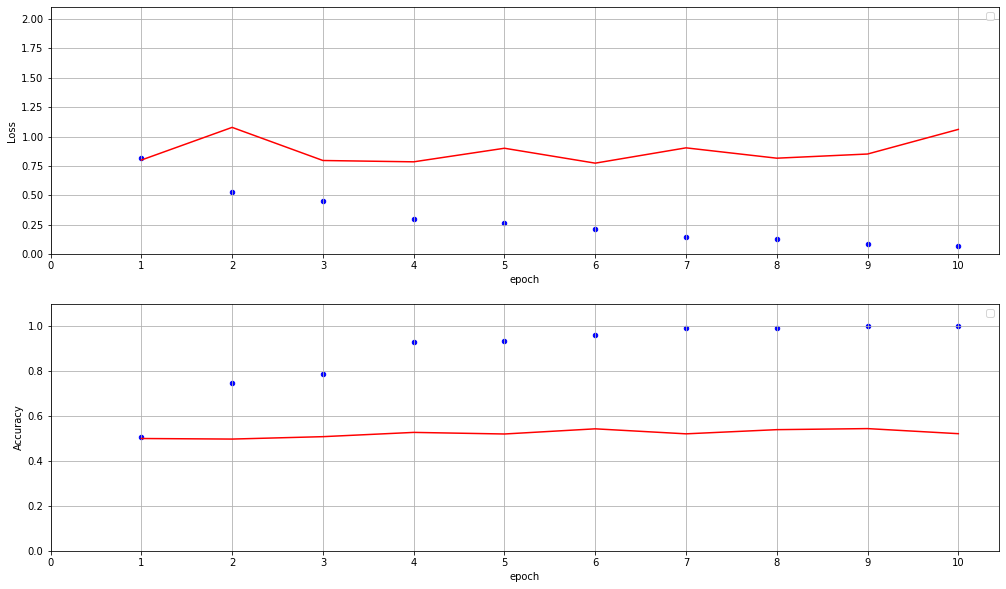

In [19]:
metrics_df = pd.DataFrame(history3.history)
metrics_df['epoch'] = metrics_df.index+1
display(metrics_df.tail())

fig = plt.figure(figsize=(17,10))
ax1, ax2 = fig.add_subplot(2,1,1), fig.add_subplot(2,1,2)
metrics_df.plot(kind='scatter', x='epoch', y='loss', ax=ax1, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_loss', ax=ax1, label='validation', color='red',)
ax1.set_ylabel("Loss")
ax1.grid('GAINSBORO')
ax1.legend([])
ax1.set_ylim(0,2.1)
ax1.set_xticks(range(0,11))

metrics_df.plot(kind='scatter', x='epoch', y='accuracy', ax=ax2, label='train', color='blue')
metrics_df.plot(kind='line', x='epoch', y='val_accuracy', ax=ax2, label='validation', color='red',)
ax2.set_ylabel("Accuracy")
ax2.grid('GAINSBORO')
ax2.set_xticks(range(0,11))
ax2.legend([])
ax2.set_ylim(0,1.1)
plt.show()

With the pretrained embeddings, we can see the model to start overfitting very quickly. Validation accuracy has high variance too. This is common for relatively small datasets. 

In [20]:
print(model2.evaluate(x_test, test_labels))
print(model3.evaluate(x_test, test_labels))

782/782 [==============================] - 1s 2ms/step - loss: 0.7688 - accuracy: 0.5004
[0.7688281536102295, 0.5003600120544434]
782/782 [==============================] - 1s 1ms/step - loss: 1.1071 - accuracy: 0.4987
[1.1070612668991089, 0.4987199902534485]


Additional References / Resources

- https://www.gutenberg.org/

- https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

- https://github.com/stanfordnlp/GloVe